In [23]:
import pandas as pd
import numpy as np
from glob import glob
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor, IsolationForest
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os

# --- Загрузка  лабораторных данных ---
def load_lab_data(data_dir='data_example/lab_data', gases=None):
    if gases is None:
        gases = ['NO2', 'CO', 'O3', 'SO2', 'H2S']

    files = glob(os.path.join(data_dir, '*_stat.csv'))
    dfs = [pd.read_csv(file) for file in files]
    df = pd.concat(dfs, ignore_index=True).sort_values('date')

    # Добавляем градиенты по каждому газу
    for gas in gases:
        signal_col = f"{gas}op1"
        temp_col = f"{gas}t"
        if signal_col in df:
            df[f'{signal_col}_grad'] = df[signal_col].diff()
        if temp_col in df:
            df[f'{temp_col}_grad'] = df[temp_col].diff()

    df['MH_grad'] = df['MH'].diff() if 'MH' in df else np.nan
    return df

# --- Универсальная функция для расчёта baseline-маски (с очисткой по IQR/Isolation Forest) ---
def compute_baseline_mask(
    df,
    gas,
    signal_col=None,
    baseline_eps=0.01,
    use_iqr=True,
    use_isolation=False,
    contamination=None,
    verbose=False
):
    """
    Формируем маску baseline: сначала просто по концентрации, потом фильтруем выбросы по IQR и/или IsolationForest.
    """
    from sklearn.ensemble import IsolationForest

    if signal_col is None:
        signal_col = f"{gas}op1"
    temp_col = f"{gas}t"

    #  Простая маска по концентрации (== 0)
    valid_mask = df[signal_col].notna()
    bl_mask = (df[gas].fillna(0) < baseline_eps) & valid_mask

    #  Фильтруем baseline по IQR (убираем выбросы по сигналу)
    if use_iqr:
        q1 = df.loc[bl_mask, signal_col].quantile(0.25)
        q3 = df.loc[bl_mask, signal_col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        iqr_mask = df[signal_col].between(lower, upper)
        bl_mask = bl_mask & iqr_mask

    #   чистим baseline с помощью Isolation Forest 
    if use_isolation:
        features = [signal_col]
        if temp_col in df: features.append(temp_col)
        if 'MH' in df: features.append('MH')
        if f"{temp_col}_grad" in df: features.append(f"{temp_col}_grad")
        if 'MH_grad' in df: features.append('MH_grad')
        iso_df = df.loc[bl_mask, features].dropna()
        if not iso_df.empty:
            # contamination  by  IQR 
            if contamination is None and use_iqr:
                extreme = (df.loc[bl_mask, signal_col] < lower) | (df.loc[bl_mask, signal_col] > upper)
                contamination_est = min(max(extreme.sum() / len(extreme), 0.001), 0.2)
            else:
                contamination_est = contamination if contamination is not None else 0.02
            if verbose:
                print(f"{gas}: estimated contamination = {contamination_est:.4f}")
            iso = IsolationForest(contamination=contamination_est, random_state=42)
            outliers = iso.fit_predict(iso_df)
            bad_idx = iso_df.index[outliers == -1]
            bl_mask.loc[bad_idx] = False

    if verbose:
        print(f"{gas}: {bl_mask.sum()} baseline (после фильтрации)")

    return bl_mask

#  маски baseline/stat для всех газов 
def add_bl_stat_masks(df, gases=None, std_thr=0.1, window=5, baseline_eps=0.001, use_isolation=True, contamination=None, verbose=True):
    if gases is None:
        gases = ['NO2', 'CO', 'O3', 'SO2', 'H2S']

    for gas in gases:
        signal_col = f"{gas}op1"

        if gas in df.columns and signal_col in df.columns:
            # Универсальная маска baseline
            df[f"{signal_col}_bl"] = compute_baseline_mask(
                df, gas,
                baseline_eps=baseline_eps,
                use_iqr=True,
                use_isolation=use_isolation,
                contamination=contamination,
                verbose=verbose
            )           

            # stat: стабильный сигнал и не baseline
            rolling_std = df[signal_col].rolling(window, center=True).std()
            df[f"{signal_col}_stat"] = (rolling_std < std_thr).fillna(False) & (~df[f"{signal_col}_bl"])

            if verbose:               
                n_total = len(df)
                n_bl = df[f'{signal_col}_bl'].sum()
                n_stat = df[f'{signal_col}_stat'].sum()
                print(f"{gas}: baseline = {n_bl}, stat = {n_stat}, всего = {n_total}")            
        else:
            df[f"{signal_col}_bl"] = False
            df[f"{signal_col}_stat"] = False
            if verbose:
                print(f"{gas}: пропущены (нет данных)")

    return df


def plot_regression_results(
    y_true, y_pred,
    x_axis=None,
    title="Regression",
    xlabel="Истинное значение",
    ylabel="Предсказание",
    line45=True
):
    plt.figure(figsize=(6, 5))
    if x_axis is not None:
        plt.scatter(x_axis, y_true, s=6, alpha=0.4, label="Истинные")
        plt.scatter(x_axis, y_pred, s=6, alpha=0.4, label="Модель")
    else:
        plt.scatter(y_true, y_pred, s=8, alpha=0.5)
    if line45:
        mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
        plt.plot([mn, mx], [mn, mx], 'k--', lw=1, label="Идеал")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def train_for_gas(
    gas_name,
    df,
    bl_method='rolling',
    stat_method='auto',
    bl_model_name='catboost',
    sens_model_name='catboost',
    draw=True,
    use_grads=False
):
    signal_col = f"{gas_name}op1"
    temp_col = f"{gas_name}t"
    hum_col = "MH"

    bl_col = f"{signal_col}_bl" if bl_method == 'rolling' else f"{signal_col}_bl_auto"
    stat_col = f"{signal_col}_stat" if stat_method == 'rolling' else f"{signal_col}_stat_auto"

    bl_mask = df[bl_col].fillna(False)
    stat_mask = df[stat_col].fillna(False)

    other_gases = ['O3']  
    base_feats = [temp_col, hum_col]
    cross_feats = [f'{g}op1' for g in other_gases if f'{g}op1' in df.columns]
    grad_feats = [f'{temp_col}_grad', 'MH_grad', f'{signal_col}_grad']

    features_bl = base_feats + cross_feats + (grad_feats if use_grads else [])

    features_stat = features_bl + [gas_name] 

    # baseline модель — по baseline точкам
    bl_df = df.loc[bl_mask].dropna(subset=[signal_col] + features_bl)
    stat_df = df.loc[stat_mask].dropna(subset=[signal_col] + features_stat)

    if len(bl_df) < 10 or len(stat_df) < 10:
        return {'gas': gas_name, 'error': 'Недостаточно данных для обучения'}

    X_bl = bl_df[features_bl].values
    y_bl = bl_df[signal_col].values
    X_stat = stat_df[features_stat].values
    y_signal = stat_df[signal_col].values
    X_target = stat_df[[gas_name]].values

    def get_model(name, **params):
        if name == 'linear': return LinearRegression(**params)
        if name == 'catboost': return CatBoostRegressor(verbose=0, random_seed=42, **params)
        if name == 'histgb': return HistGradientBoostingRegressor(random_state=42, **params)
        if name == 'xgb': return xgb.XGBRegressor(random_state=42, **params)
        raise ValueError(f"Неизвестная модель: {name}")

    # Baseline 
    bl_model = get_model(bl_model_name)
    bl_model.fit(X_bl, y_bl)
    y_bl_pred = bl_model.predict(X_bl)

    # Sens-модель (обучается на разнице signal - baseline)
    bl_pred_for_sens = bl_model.predict(X_stat[:, :len(features_bl)])
    delta_signal = y_signal - bl_pred_for_sens
    sens_model = get_model(sens_model_name)
    sens_model.fit(X_target, delta_signal)
    sens_pred = sens_model.predict(X_target)

    r2_bl = r2_score(y_bl, y_bl_pred)
    r2_sens = r2_score(delta_signal, sens_pred)

    if draw:
        plot_regression_results(
            y_true=y_bl, y_pred=y_bl_pred,
            title=f"{gas_name} — BL model: R2 = {r2_bl:.3f}",
            xlabel="op1_bl (истинный)",
            ylabel="op1_bl (предсказанный)"
        )
        plot_regression_results(
            y_true=delta_signal, y_pred=sens_pred,
            x_axis=X_target,
            title=f"{gas_name} — Sens model: R2 = {r2_sens:.3f}",
            xlabel=f'{gas_name} (мкг/м³)',
            ylabel=f'delta_signal',
                 line45=False
        )

    return {
        'gas': gas_name,
        'n_bl': len(bl_df),
        'n_stat': len(stat_df),
        'R2_bl': r2_bl,
        'R2_sens': r2_sens,
        'model_bl': bl_model,
        'model_sens': sens_model
    }


# --- Обучение baseline и регрессии концентрации газа ---
def train_for_gas_conc(
    gas_name,
    df,
    bl_method='rolling',
    stat_method='auto',
    bl_model_name='catboost',
    conc_model_name='catboost',
    draw=True,
    use_grads=False
):
    """
    Строит baseline-модель и регрессию для восстановления концентрации газа.
    use_grads: использовать ли градиенты (по умолчанию False)
    """
    signal_col = f"{gas_name}op1"
    temp_col = f"{gas_name}t"
    hum_col = "MH"

    bl_col = f"{signal_col}_bl" if bl_method == 'rolling' else f"{signal_col}_bl_auto"
    stat_col = f"{signal_col}_stat" if stat_method == 'rolling' else f"{signal_col}_stat_auto"

    bl_mask = df[bl_col].fillna(False)
    stat_mask = df[stat_col].fillna(False)

    other_gases = ['O3']  
    base_feats = [temp_col, hum_col]
    cross_feats = [f'{g}op1' for g in other_gases if f'{g}op1' in df.columns]
    grad_feats = [f'{temp_col}_grad', 'MH_grad', f'{signal_col}_grad']

    features_bl = base_feats + cross_feats + (grad_feats if use_grads else [])

    features_conc = [signal_col, temp_col, hum_col] + cross_feats + (grad_feats if use_grads else [])

     # baseline модель — по baseline точкам
    bl_df = df.loc[bl_mask].dropna(subset=[signal_col] + features_bl)
    stat_df = df.loc[stat_mask].dropna(subset=features_conc + [gas_name])

    if len(bl_df) < 10 or len(stat_df) < 10:
        return {'gas': gas_name, 'error': 'Недостаточно данных для обучения'}

    X_bl = bl_df[features_bl].values
    y_bl = bl_df[signal_col].values

    X_conc = stat_df[features_conc].values
    y_conc = stat_df[gas_name].values

    def get_model(name, **params):
        if name == 'linear': return LinearRegression(**params)
        if name == 'catboost': return CatBoostRegressor(verbose=0, random_seed=42, **params)
        if name == 'histgb': return HistGradientBoostingRegressor(random_state=42, **params)
        if name == 'xgb': return xgb.XGBRegressor(random_state=42, **params)
        raise ValueError(f"Неизвестная модель: {name}")

    # Baseline модель
    bl_model = get_model(bl_model_name)
    bl_model.fit(X_bl, y_bl)
    y_bl_pred = bl_model.predict(X_bl)

    # Модель для восстановления концентрации
    conc_model = get_model(conc_model_name)
    conc_model.fit(X_conc, y_conc)
    y_conc_pred = conc_model.predict(X_conc)

    r2_bl = r2_score(y_bl, y_bl_pred)
    r2_conc = r2_score(y_conc, y_conc_pred)

    if draw:
        plot_regression_results(
            y_true=y_bl, y_pred=y_bl_pred,
            title=f"{gas_name} — BL model: R2 = {r2_bl:.3f}",
            xlabel="op1_bl (истинный)",
            ylabel="op1_bl (предсказанный)"
        )
        plot_regression_results(
            y_true=y_conc, y_pred=y_conc_pred,
            title=f"{gas_name} — Regression model: R2 = {r2_conc:.3f}",
            xlabel=f'{gas_name} (истинная)',
            ylabel=f'{gas_name} (предсказанная)'
        )



    return {
        'gas': gas_name,
        'n_bl': len(bl_df),
        'n_stat': len(stat_df),
        'R2_bl': r2_bl,
        'R2_conc': r2_conc,
        'model_bl': bl_model,
        'model_conc': conc_model
    }



NO2: estimated contamination = 0.0010
NO2: 391159 baseline (после фильтрации)
NO2: baseline = 391159, stat = 0, всего = 921600
{'gas': 'NO2', 'n_bl': 387782, 'n_stat': 77644, 'R2_bl': 0.9354170720378951, 'R2_conc': 0.9852166818569038, 'model_bl': <catboost.core.CatBoostRegressor object at 0x70d7d8ba2fb0>, 'model_conc': <catboost.core.CatBoostRegressor object at 0x70d7d8ba2aa0>}


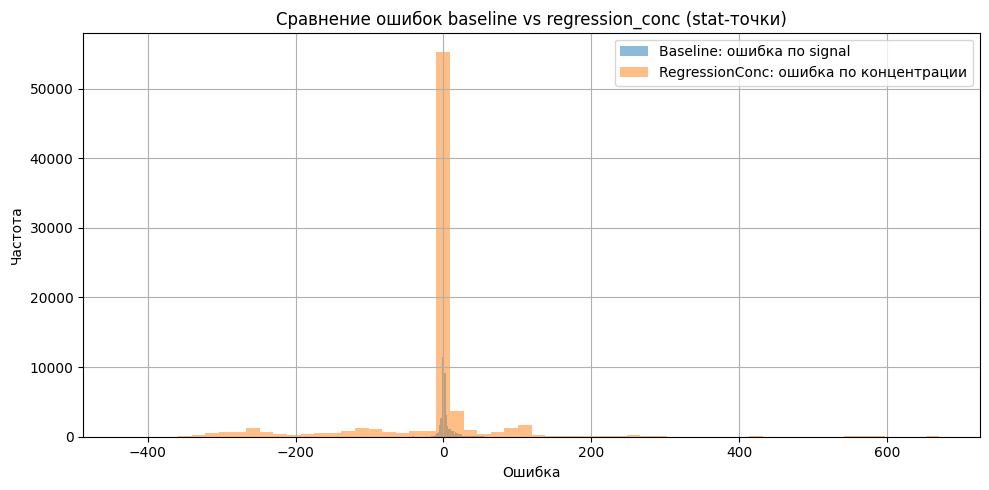

Baseline: std=7.605, MAE=3.400
RegressionConc: std=90.105, MAE=39.043


In [30]:
df = load_lab_data(data_dir='data_example/lab_data', gases=['NO2'])
df = add_bl_stat_masks(df, gases=['NO2'], std_thr=1.8, window=7, use_isolation=True, contamination=None, verbose=True)

# --- Обучение обеих моделей ---
result_sens = train_for_gas('NO2', df, use_grads=False, draw=False)
result_conc = train_for_gas_conc('NO2', df, use_grads=False, draw=False)
print(result_conc)

signal_col = 'NO2op1'
features_bl = ['NO2t', 'MH','O3op1']   # или с градиентами если надо
features_conc = [signal_col, 'NO2t', 'MH','O3']
all_cols = features_bl + features_conc + ['NO2']

# --- Только stat-точки, без NaN в нужных колонках ---
stat_mask = df['NO2op1_stat_auto'].fillna(False)
df_stat = df.loc[stat_mask].dropna(subset=all_cols).copy()

# --- Ошибка baseline ---
bl_model = result_conc['model_bl']
X_bl = df_stat[features_bl].values
y_bl_true = df_stat[signal_col].values
y_bl_pred = bl_model.predict(X_bl)
err_bl = y_bl_true - y_bl_pred

# --- Ошибка regression_conc ---
conc_model = result_conc['model_conc']
X_conc = df_stat[features_conc].values
y_conc_true = df_stat['NO2'].values
y_conc_pred = conc_model.predict(X_conc)
err_conc = y_conc_true - y_conc_pred

# --- Визуализация ---
plt.figure(figsize=(10,5))
plt.hist(err_bl, bins=60, alpha=0.5, label='Baseline: ошибка по signal', color='C0')
plt.hist(err_conc, bins=60, alpha=0.5, label='RegressionConc: ошибка по концентрации', color='C1')
plt.legend()
plt.title('Сравнение ошибок baseline vs regression_conc (stat-точки)')
plt.xlabel('Ошибка')
plt.ylabel('Частота')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Краткая статистика ---
print(f"Baseline: std={np.std(err_bl):.3f}, MAE={np.mean(np.abs(err_bl)):.3f}")
print(f"RegressionConc: std={np.std(err_conc):.3f}, MAE={np.mean(np.abs(err_conc)):.3f}")



77647 ['NO2t', 'MH', 'O3op1', 'NO2op1', 'NO2t', 'MH', 'O3op1', 'NO2']


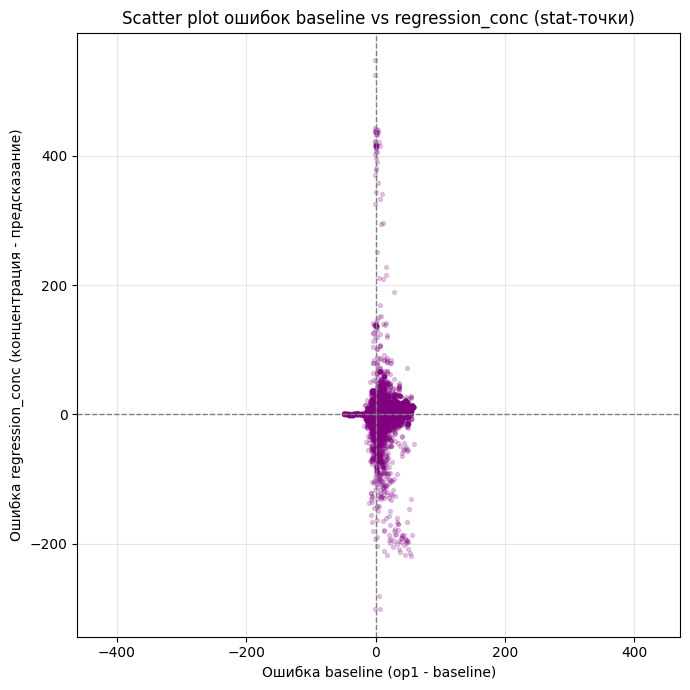

Корреляция ошибок: 0.022


In [41]:
# --- Готовим все данные только для строк без NaN ---
other_gases = ['O3']  # 

features_bl = ['NO2t', 'MH'] + [f'{g}op1' for g in other_gases if f'{g}op1' in df_stat.columns]
features_conc = ['NO2op1', 'NO2t', 'MH'] + [f'{g}op1' for g in other_gases if f'{g}op1' in df_stat.columns]

all_cols = features_bl + features_conc + ['NO2']
stat_mask = df['NO2op1_stat_auto'].fillna(False)
df_stat = df.loc[stat_mask].dropna(subset=all_cols).copy()
print(stat_mask.sum(),all_cols)
# --- Ошибки baseline ---
bl_model = result_conc['model_bl']
X_bl = df_stat[features_bl].values
y_bl_true = df_stat['NO2op1'].values
y_bl_pred = bl_model.predict(X_bl)
err_bl = y_bl_true - y_bl_pred

# --- Ошибки regression_conc ---
conc_model = result_conc['model_conc']
X_conc = df_stat[features_conc].values
y_conc_true = df_stat['NO2'].values
y_conc_pred = conc_model.predict(X_conc)
err_conc = y_conc_true - y_conc_pred

# --- SCATTER PLOT ошибок ---
plt.figure(figsize=(7, 7))
plt.scatter(err_bl, err_conc, alpha=0.2, s=8, c='purple')
plt.axhline(0, color='gray', linestyle='--', lw=1)
plt.axvline(0, color='gray', linestyle='--', lw=1)
plt.xlabel("Ошибка baseline (op1 - baseline)")
plt.ylabel("Ошибка regression_conc (концентрация - предсказание)")
plt.title("Scatter plot ошибок baseline vs regression_conc (stat-точки)")
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

corr = np.corrcoef(err_bl, err_conc)[0,1]
print(f"Корреляция ошибок: {corr:.3f}")


['NO2op1', 'NO2t', 'MH', 'O3op1']                        date      T_THC     RH_THC   CO  NO2  H2S  SO2  \
116431  2025-05-22 20:31:00  40.100000  20.200000  0.0  0.0  0.0  0.0   
116432  2025-05-22 20:32:00  40.116667  20.191667  0.0  0.0  0.0  0.0   
116433  2025-05-22 20:33:00  40.133333  20.175000  0.0  0.0  0.0  0.0   
116434  2025-05-22 20:34:00  40.200000  20.191667  0.0  0.0  0.0  0.0   
346835  2025-05-22 20:35:00  40.200000  20.100000  0.0  0.0  0.0  0.0   
...                     ...        ...        ...  ...  ...  ...  ...   
515008  2025-06-08 15:28:00 -22.400000  56.900000  0.0  0.0  0.0  0.0   
515009  2025-06-08 15:29:00 -22.400000  56.825000  0.0  0.0  0.0  0.0   
140609  2025-06-08 15:29:00 -22.400000  56.825000  0.0  0.0  0.0  0.0   
515010  2025-06-08 15:30:00 -22.400000  56.841667  0.0  0.0  0.0  0.0   
140610  2025-06-08 15:30:00 -22.400000  56.841667  0.0  0.0  0.0  0.0   

            NO2op1      NO2op2       NO2t  ...  SO2t  H2Sop1_stat_auto  \
116431  239.763

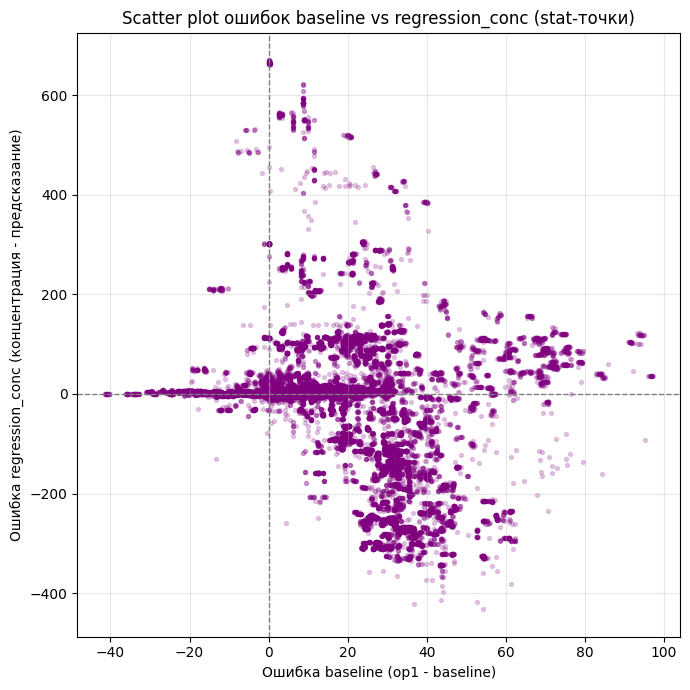

Корреляция ошибок: -0.303


In [46]:
    # --- Готовим все данные только для строк без NaN ---
    other_gases = ['O3']  # 

    features_bl = ['NO2t', 'MH'] + [f'{g}op1' for g in other_gases if f'{g}op1' in df_stat.columns]
    features_conc = ['NO2op1', 'NO2t', 'MH'] + [f'{g}op1' for g in other_gases if f'{g}op1' in df_stat.columns]
    all_cols = features_bl + features_conc + ['NO2']

    stat_mask = df['NO2op1_stat_auto'].fillna(False)
    df_stat = df.loc[stat_mask].dropna(subset=all_cols).copy()
    print(features_conc,df_stat )

    # --- Ошибки baseline ---
    bl_model = result_conc['model_bl']
    X_bl = df_stat[['NO2t', 'MH','O3']].values
    y_bl_true = df_stat['NO2op1'].values
    y_bl_pred = bl_model.predict(X_bl)
    err_bl = y_bl_true - y_bl_pred

    # --- Ошибки regression_conc ---
    conc_model = result_conc['model_conc']
    X_conc = df_stat[['NO2op1', 'NO2t', 'MH','O3']].values
    y_conc_true = df_stat['NO2'].values
    y_conc_pred = conc_model.predict(X_conc)
    err_conc = y_conc_true - y_conc_pred

    # --- SCATTER PLOT ошибок ---
    plt.figure(figsize=(7, 7))
    plt.scatter(err_bl, err_conc, alpha=0.2, s=8, c='purple')
    plt.axhline(0, color='gray', linestyle='--', lw=1)
    plt.axvline(0, color='gray', linestyle='--', lw=1)
    plt.xlabel("Ошибка baseline (op1 - baseline)")
    plt.ylabel("Ошибка regression_conc (концентрация - предсказание)")
    plt.title("Scatter plot ошибок baseline vs regression_conc (stat-точки)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    corr = np.corrcoef(err_bl, err_conc)[0,1]
    print(f"Корреляция ошибок: {corr:.3f}")


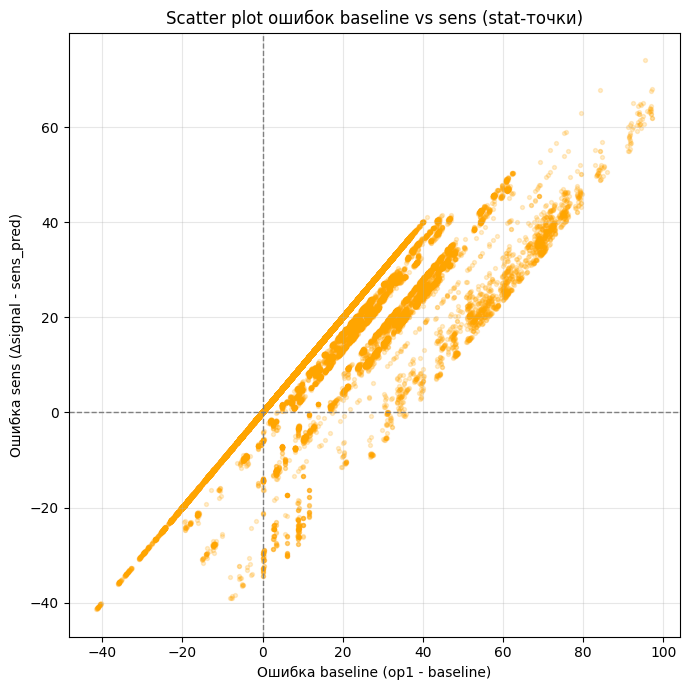

Корреляция ошибок: 0.911


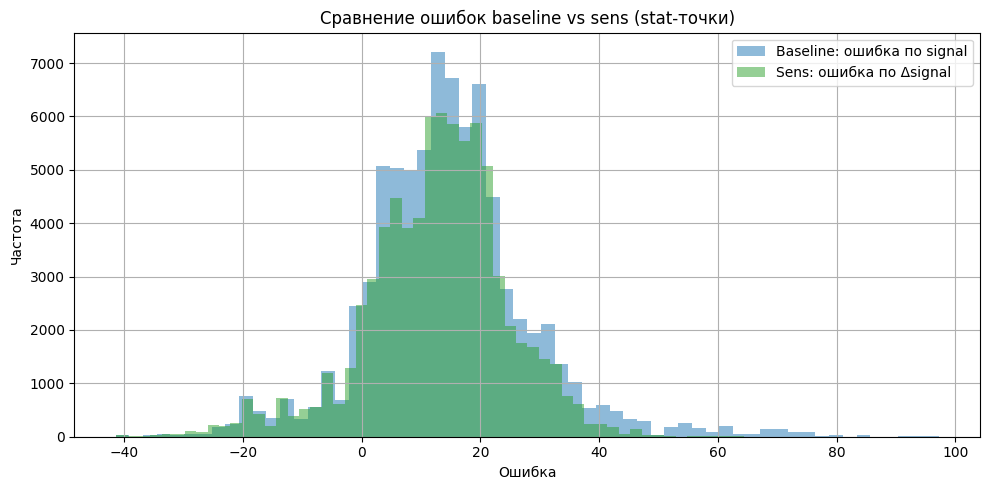

Baseline: std=14.190, MAE=16.426
Sens: std=12.030, MAE=14.958


In [47]:
# --- Только stat-точки без NaN ---
features_bl = ['NO2t', 'MH','O3']
all_cols = features_bl + ['NO2op1', 'NO2']
stat_mask = df['NO2op1_stat_auto'].fillna(False)
df_stat = df.loc[stat_mask].dropna(subset=all_cols).copy()

# --- Ошибка baseline ---
bl_model = result_sens['model_bl']
X_bl = df_stat[features_bl].values
y_bl_true = df_stat['NO2op1'].values
y_bl_pred = bl_model.predict(X_bl)
err_bl = y_bl_true - y_bl_pred   # Ошибка baseline (signal - baseline)

# --- Ошибка sens ---
sens_model = result_sens['model_sens']
X_target = df_stat[['NO2']].values
sens_pred = sens_model.predict(X_target)
delta_signal_true = y_bl_true - y_bl_pred  # = op1 - baseline (совпадает с err_bl)
err_sens = delta_signal_true - sens_pred   # Ошибка sens (Δsignal - предсказание)

# --- SCATTER PLOT baseline vs sens ---
plt.figure(figsize=(7, 7))
plt.scatter(err_bl, err_sens, alpha=0.2, s=8, c='orange')
plt.axhline(0, color='gray', linestyle='--', lw=1)
plt.axvline(0, color='gray', linestyle='--', lw=1)
plt.xlabel("Ошибка baseline (op1 - baseline)")
plt.ylabel("Ошибка sens (Δsignal - sens_pred)")
plt.title("Scatter plot ошибок baseline vs sens (stat-точки)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

corr = np.corrcoef(err_bl, err_sens)[0,1]
print(f"Корреляция ошибок: {corr:.3f}")

# --- Гистограммы для полноты ---
plt.figure(figsize=(10,5))
plt.hist(err_bl, bins=60, alpha=0.5, label='Baseline: ошибка по signal', color='C0')
plt.hist(err_sens, bins=60, alpha=0.5, label='Sens: ошибка по Δsignal', color='C2')
plt.legend()
plt.title('Сравнение ошибок baseline vs sens (stat-точки)')
plt.xlabel('Ошибка')
plt.ylabel('Частота')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Baseline: std={np.std(err_bl):.3f}, MAE={np.mean(np.abs(err_bl)):.3f}")
print(f"Sens: std={np.std(err_sens):.3f}, MAE={np.mean(np.abs(err_sens)):.3f}")


NO2: estimated contamination = 0.0010
NO2: 391159 baseline (после фильтрации)
NO2: baseline = 391159, stat = 0, всего = 921600


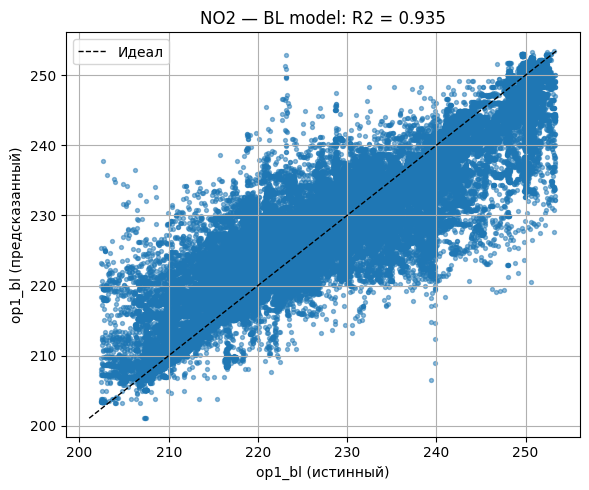

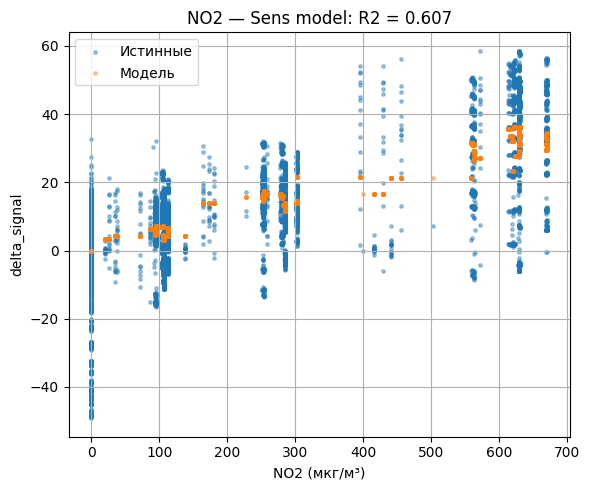


====== Итоги обучения для газа: NO2 ======
Количество baseline (bl):   387782
Количество рабочих (stat):  77644
Качество baseline (BL):     R2 = 0.935
Качество sens-модели (Sens):R2 = 0.607



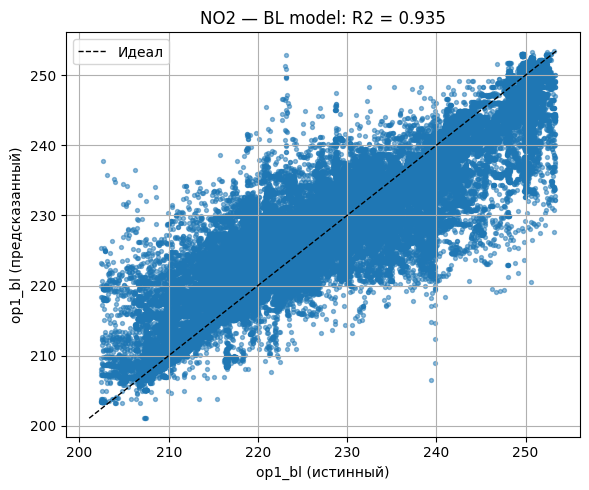

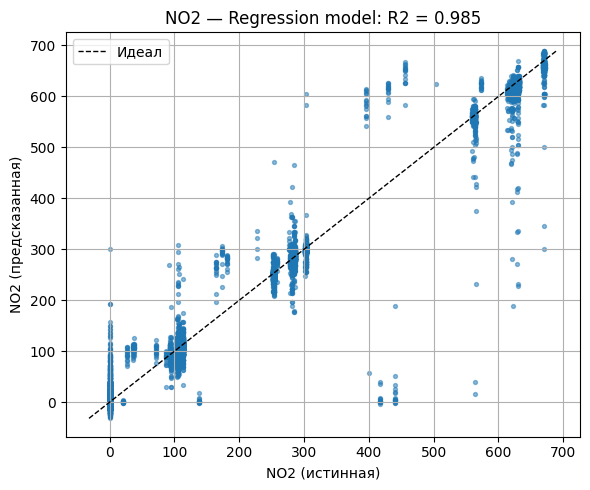


====== Итоги обучения для газа: NO2 ======
Количество baseline (bl):   387782
Количество рабочих (stat):  77644
Качество baseline (BL):     R2 = 0.935
Качество regression-модели (conc): R2 = 0.985



In [48]:


df = load_lab_data(data_dir='data_example/lab_data', gases=['NO2'])
df = add_bl_stat_masks(df, gases=['NO2'], std_thr=1.8, window=7, use_isolation=True, contamination=None, verbose=True)
result = train_for_gas(
    'NO2', 
    df, 
    bl_method='rolling', 
    stat_method='auto', 
    bl_model_name='catboost', 
    sens_model_name='catboost',
    use_grads=False,    
    draw=True)

if 'error' in result:
    print(f"[{result['gas']}] ❌ Обучение не выполнено: {result['error']}")
else:
    print(f"\n====== Итоги обучения для газа: {result['gas']} ======")
    print(f"Количество baseline (bl):   {result['n_bl']}")
    print(f"Количество рабочих (stat):  {result['n_stat']}")
    print(f"Качество baseline (BL):     R2 = {result['R2_bl']:.3f}")
    print(f"Качество sens-модели (Sens):R2 = {result['R2_sens']:.3f}")
    if result['n_stat'] == 0:
        print(f"⚠️  Нет ни одной рабочей точки stat! Проверь разметку stat (auto/rolling), rolling-std, маску baseline.")
    print("========================================\n")


result = train_for_gas_conc(
    gas_name='NO2',
    df=df,
    bl_method='rolling',
    stat_method='auto',
    bl_model_name='catboost',
    conc_model_name='catboost',
    use_grads=False,    
    draw=True
)



if 'error' in result:
    print(f"[{result['gas']}] ❌ Обучение не выполнено: {result['error']}")
else:
    print(f"\n====== Итоги обучения для газа: {result['gas']} ======")
    print(f"Количество baseline (bl):   {result['n_bl']}")
    print(f"Количество рабочих (stat):  {result['n_stat']}")
    print(f"Качество baseline (BL):     R2 = {result['R2_bl']:.3f}")
    print(f"Качество regression-модели (conc): R2 = {result['R2_conc']:.3f}")
    if result['n_stat'] == 0:
        print(f"⚠️  Нет ни одной рабочей точки stat! Проверь разметку stat (auto/rolling), rolling-std, маску baseline.")
    print("========================================\n")